In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### Plotting Utilities

In [36]:
def plot3D(px,py,pz,clist,emphPoints = [],cmap='plasma',title='',shadow=False, useCMAP = True,xLabel='',yLabel='',zLabel='',savefig='',saveN = 1, setRange = 0):
    elev = 30
    azim = 60

    viewVect = [np.cos(np.pi*180/elev)*np.sin(np.pi*180/azim),np.cos(np.pi*180/elev)*np.cos(np.pi*180/azim),np.cos(np.pi*180/elev)]
    
    thetalist = np.linspace(0,2*np.pi,saveN + 1)
    thetalist = thetalist[:-1]
    
    projMat = np.array([px,py])

    s = ''
    
    for idx in range(saveN):
        theta = thetalist[idx]
        rotMat = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        
        rotx,roty = np.dot(rotMat,projMat)
        rotz = pz
        clistRot = clist
        
        p = np.array([rotx,roty,rotz])
        dots = np.array(np.dot(viewVect,p))
        sort = dots.argsort()

        fig, ax = plt.subplots(figsize = (10,10))
        
        ax.set_alpha(0)
        ax.axis('off')

        ax = fig.add_subplot(projection='3d')

        ax.patch.set_alpha(0)

        Xdist = px.max() - px.min()
        Xcntr = (px.max() + px.min())/2.0
        Ydist = py.max() - py.min()
        Ycntr = (py.max() + py.min())/2.0
        Zdist = pz.max() - pz.min()
        Zcntr = (pz.max() + pz.min())/2.0

        if setRange == 0:
            dist = 0.55*max(Xdist,Ydist,Zdist)
        else:
            dist = 0.55*setRange

        for p in emphPoints:
            ax.scatter([rotx[p]],[roty[p]],[rotz[p]],c='C1',s=200)
            if shadow:
                ax.scatter([rotx[p]],[roty[p]],[Zcntr - dist],c='black',alpha=0.5)
                ax.scatter([rotx[p]],[Ycntr + dist],[rotz[p]],c='black',alpha=0.5)
                ax.scatter([Xcntr - dist],[roty[p]],[rotz[p]],c='black',alpha=0.5)
        
        rotx = rotx[sort]
        roty = roty[sort]
        rotz = rotz[sort]
        clistRot = np.array(clistRot)[sort]
        
        if useCMAP:
            s = ax.scatter(rotx,roty,rotz,c=clistRot,s = 3, linewidth=0.2,cmap = cmap)
        else:
            s = ax.scatter(rotx,roty,rotz,c=clistRot,s = 3, linewidth=0.2)


        ax.set_xlim([Xcntr - dist, Xcntr + dist])
        ax.set_ylim([Ycntr - dist, Ycntr + dist])
        ax.set_zlim([Zcntr - dist, Zcntr + dist])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        #ax.set_axis_off()
        #plt.show()

        if shadow:
            #fig = plt.figure(figsize = (10,10))
            #ax = fig.gca(projection='3d')
            ax.view_init(30,-60)

            ax.scatter(rotx,roty,[Zcntr - dist for p in rotz],c='black',s=3, alpha=0.01)
            ax.scatter(rotx,[Ycntr + dist for p in roty],rotz,c='black',s=3,alpha=0.01)
            ax.scatter([Xcntr - dist for p in rotx],roty,rotz,c='black',s=3,alpha=0.01)

            ax.set_xlim([Xcntr - dist, Xcntr + dist])
            ax.set_ylim([Ycntr - dist, Ycntr + dist])
            ax.set_zlim([Zcntr - dist, Zcntr + dist])

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

            #ax.set_axis_off()
        ax.set_xlabel(xLabel,fontsize=16)
        ax.set_ylabel(yLabel,fontsize=16)
        ax.set_zlabel(zLabel,fontsize=16)
        
        
        if title == '':
            pass
        else:
            plt.title(title,fontsize=30)

        if savefig == '':
            cb = plt.colorbar(s)
            plt.show()
        else:
            cb = plt.colorbar(s)
            plt.savefig(savefig+str(idx)+'.png')
            plt.close()
  
def trianglePlot(arry,clist,emphPoints = [],dim=2):  
  ranges = [arry[:,idx].max()-arry[:,idx].min() for idx in range(dim+1)]
  axesDist = 0.6*max(ranges)
  
  figs,axs = plt.subplots(nrows=dim,ncols=dim,figsize=(15,15))
  for row in range(dim-1,-1,-1):
      for col in range(dim-1,-1,-1):
          if col >= row:
              py = arry[:,row]
              px = arry[:,col+1]
              
              centerX = (px.max()+px.min())/2
              centerY = (py.max()+py.min())/2
              
              sc1 = axs[row,col].scatter(px,py,s=5,c=clist,edgecolor='black',linewidth=0.2, cmap='plasma')
              for p in emphPoints:
                  axs[row,col].scatter([px[0]],[py[0]],s=100,c='C1',edgecolor='black',linewidth=0.2)
              
              axs[row,col].set_xlim([centerX-axesDist,centerX+axesDist])
              axs[row,col].set_ylim([centerY-axesDist,centerY+axesDist])
              if row != col:
                  axs[row,col].set_xticks([])
                  axs[row,col].set_yticks([])
              if row == col:
                  axs[row,col].set_ylabel('direction '+str(row+1))
                  axs[row,col].set_xlabel('direction '+str(col+2))
                  
              axs[row,col].ticklabel_format(style='sci',scilimits=(-2,2),axis='both')
          else:
              axs[row,col].axis('off')
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()
    

### Clustering (Institutional Characteristics)

In [37]:
filepath = "../datasets/IPEDS_Dataset_Encoded/Institutional Characteristics/IC_2015-2021_data.csv"
institutional_chars = pd.read_csv(filepath, index_col=0, low_memory= False)


In [38]:
missing = institutional_chars.isna().sum()
missing /= institutional_chars.shape[0]
missing *=100
missing = missing.to_frame().rename(columns={0:'Percent Of Missing Values'})


In [39]:
institutional_chars.dropna(axis = 1, inplace = True)
institutional_chars.head()

,peo1istr,peo2istr,peo3istr,peo4istr,peo5istr,peo6istr,cntlaffi,pubprime,pubsecon,relaffil,...,assoc3,assoc4,assoc5,assoc6,sport1,confno1,sport2,sport3,sport4,year
unitid,,,,,,,,,,,,,,,,,,,,,
100654,Implied no,Yes,Implied no,Implied no,Implied no,Implied no,Public,State,Implied no,Not applicable,...,Implied no,Implied no,Implied no,Implied no,Yes,Southwestern Athletic Conference,Yes,Yes,Yes,2021
100663,Implied no,Yes,Yes,Implied no,Implied no,Implied no,Public,State,Implied no,Not applicable,...,Implied no,Implied no,Implied no,Implied no,Yes,Conference USA,Yes,Yes,Yes,2021
100690,Implied no,Yes,Implied no,Implied no,Implied no,Implied no,Private not-for-profit (religious affiliation),Not applicable,Not applicable,Churches of Christ,...,Implied no,Implied no,Implied no,Implied no,No,Not applicable,No,No,No,2021
100706,Implied no,Yes,Yes,Yes,Implied no,Implied no,Public,State,Implied no,Not applicable,...,Implied no,Implied no,Implied no,Implied no,No,Not applicable,Yes,Yes,Yes,2021
100724,Yes,Yes,Implied no,Implied no,Implied no,Yes,Public,State,Implied no,Not applicable,...,Implied no,Implied no,Implied no,Implied no,Yes,Southwestern Athletic Conference,Yes,Yes,Yes,2021


In [40]:
drop_columns = [c for c in institutional_chars.columns if institutional_chars[c].nunique() > 5]
pruned_institutional_chars = institutional_chars.drop(drop_columns, axis = 1)

In [41]:
pruned_institutional_chars.columns

Index(['peo1istr', 'peo2istr', 'peo3istr', 'peo4istr', 'peo5istr', 'peo6istr',
       'cntlaffi', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6',
       'level7', 'level8', 'level12', 'level17', 'level18', 'level19', 'ft_ug',
       'ft_ftug', 'ftgdnidp', 'pt_ug', 'pt_ftug', 'ptgdnidp', 'docpp',
       'docppsp', 'openadmp', 'vet1', 'vet2', 'vet3', 'vet4', 'vet5',
       'credits1', 'credits2', 'credits3', 'credits4', 'slo5', 'slo51',
       'slo52', 'slo53', 'slo6', 'slo7', 'slo8', 'slo81', 'slo82', 'slo83',
       'slo9', 'stusrv1', 'stusrv2', 'stusrv3', 'stusrv4', 'stusrv8',
       'stusrv9', 'tuitpl', 'tuitpl1', 'tuitpl2', 'tuitpl3', 'tuitpl4',
       'dstnced1', 'dstnced2', 'dstnced3', 'distnced', 'disab', 'alloncam',
       'tuitvary', 'room', 'board', 'athassoc', 'assoc1', 'assoc2', 'assoc3',
       'assoc4', 'assoc5', 'assoc6', 'sport1', 'sport2', 'sport3', 'sport4'],
      dtype='object')

In [42]:
from prince import MCA

mca = MCA(n_components = 10, n_iter = 3, random_state = 101)
mca.fit(pruned_institutional_chars)
inst_chars_mca = mca.transform(pruned_institutional_chars)
inst_chars_mca.head()


,0,1,2,3,4,5,6,7,8,9
100654,-0.064932,-0.324822,0.712717,0.680602,-0.196434,0.003036,-0.008160,-0.019827,0.071194,0.017372
100663,-0.066357,-0.332046,0.827903,0.970389,-0.088646,0.003289,-0.003929,0.417252,-0.040441,-0.266409
100690,-0.052886,-0.213908,0.398985,-0.228401,0.488422,-0.007134,0.037315,-0.029341,-0.364206,0.250035
100706,-0.066514,-0.320926,0.764592,0.809643,-0.146024,0.002182,-0.002377,0.400736,-0.077567,-0.179038
100724,-0.063264,-0.304502,0.695659,0.755640,-0.088632,0.003428,-0.009632,0.260147,0.049318,-0.106100


In [43]:
inst_chars_mca.index.name = "unitid"

In [44]:
mca.explained_inertia_

[0.21460633176110797,
 0.17793787049221904,
 0.15190074281822802,
 0.06512731481471334,
 0.04151032388001643,
 0.03429842357170866,
 0.02861280459094703,
 0.020338826089658483,
 0.013701464288571035,
 0.012901664950861454]

#### Clustering

In [67]:
import numpy as np
from scipy import stats
inst_chars_mca_no_outliers = inst_chars_mca[(np.abs(stats.zscore(inst_chars_mca)) < 3).all(axis=1)]
inst_chars_mca_unique_per_school = inst_chars_mca_no_outliers.groupby(by = inst_chars_mca_no_outliers.index).mean()


In [71]:
# X = inst_chars_mca_unique_per_school.values

In [77]:
import numpy as np
from scipy import stats
inst_chars_mca_no_outliers = inst_chars_mca[(np.abs(stats.zscore(inst_chars_mca)) < 3).all(axis=1)]
X = inst_chars_mca_no_outliers.values

GMM

In [78]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7)
yhat = gmm.fit_predict(X)

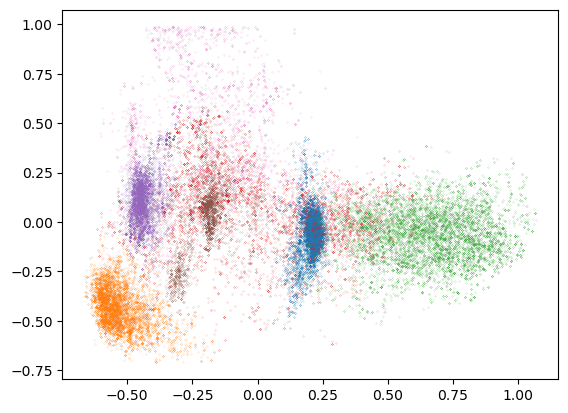

In [79]:
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    plt.scatter(X[row_ix, 3], X[row_ix, 4], s = 0.01)

plt.show()

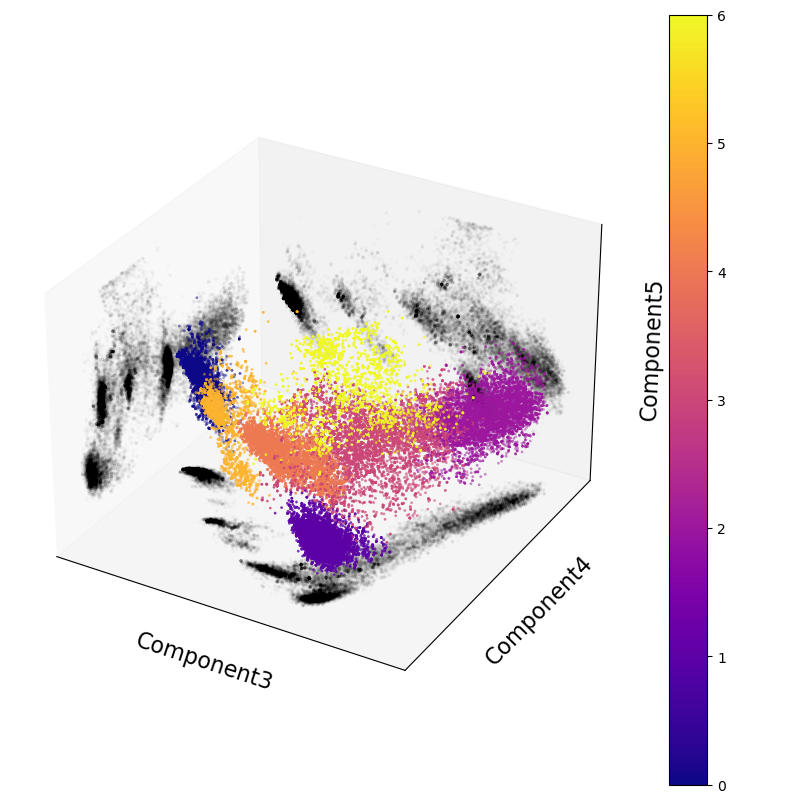

In [80]:
color = yhat

plot3D(X[:,2], X[:,3], X[:,4], color, shadow=True, xLabel = 'Component3', yLabel = 'Component4', zLabel = 'Component5')

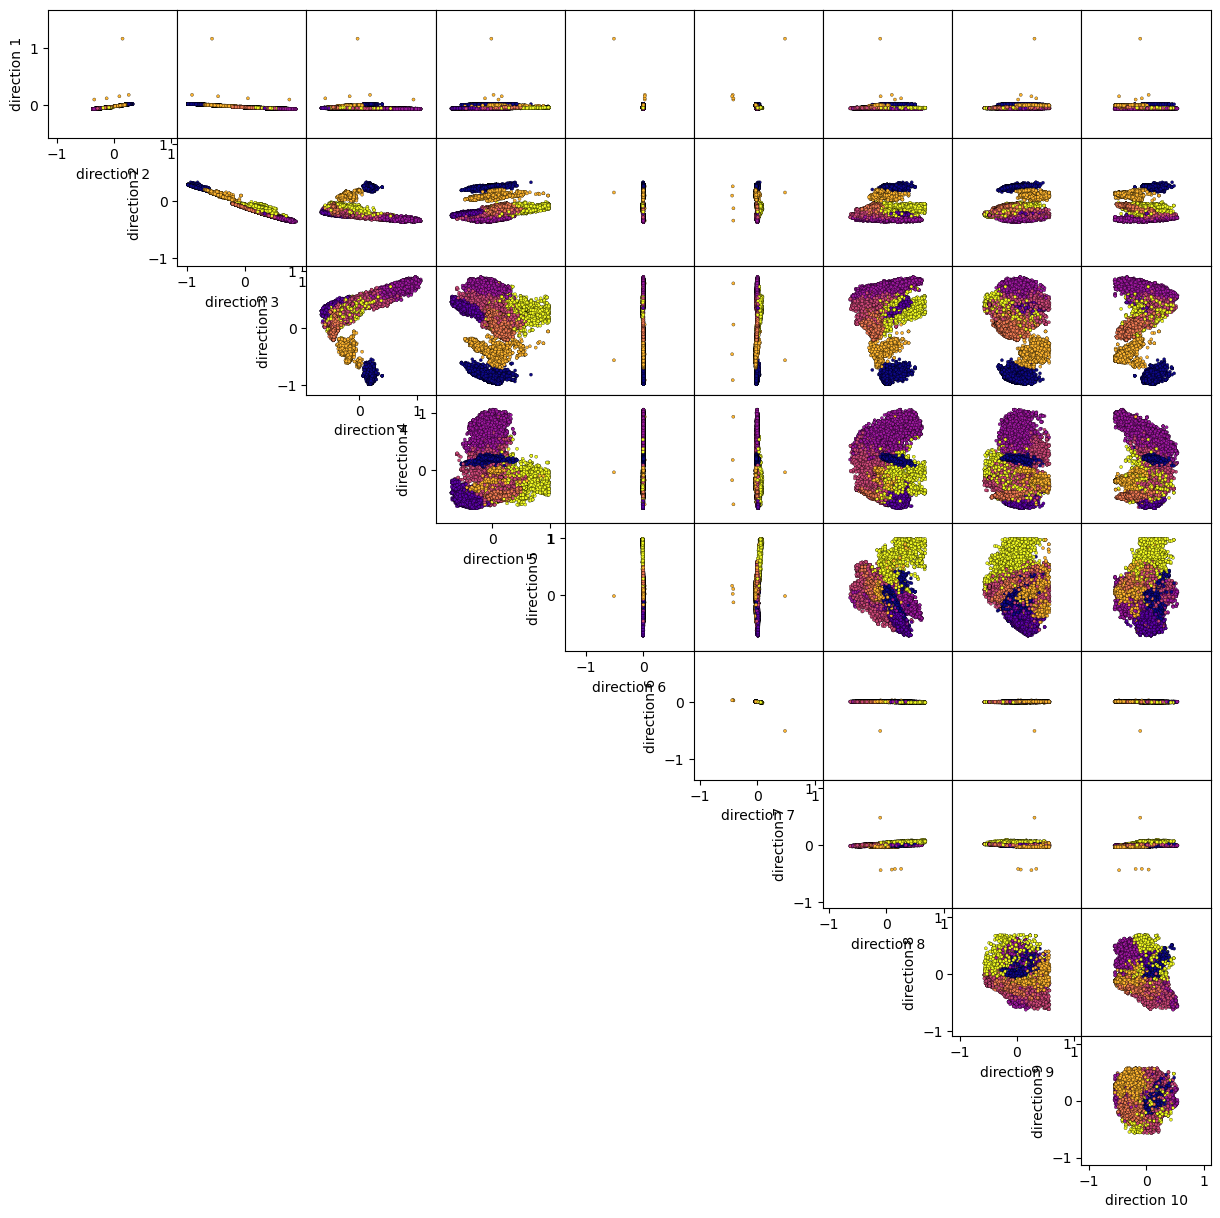

In [82]:
trianglePlot(arry = X, clist = color, dim = 9)

In [92]:
schools = inst_chars_mca_no_outliers.index
ic_cluster = yhat
ic_cluster_all_years = pd.DataFrame({"ic_cluster": ic_cluster}, index = schools) 

In [93]:
ic_cluster_df = ic_cluster_all_years.groupby(ic_cluster_all_years.index).agg(pd.Series.mode)

In [97]:
ic_cluster_df.to_csv("../datasets/Clusters/IC_CLUSTER.csv")

### Clustering (Institutional Finances)

In [98]:
filepath = "../datasets/IPEDS_Dataset_Encoded/Institutional Finances/F_F2_1415-1920_data.csv"
institutional_finance = pd.read_csv(filepath, index_col=0, low_memory= False)

In [99]:
missing = institutional_finance.isna().sum()
missing /= institutional_finance.shape[0]
missing *=100
missing = missing.to_frame().rename(columns={0:'Percent Of Missing Values'})
missing

,Percent Of Missing Values
f2a01,11.680657
f2a02,11.680657
f2a03,11.680657
f2a03a,11.680657
f2a04,11.680657
...,...
f2i03,85.533131
f2i04,85.533131
f2i05,85.533131
f2i06,85.533131


In [100]:
threshold = 30
institutional_finance_over_threshold_missing = institutional_finance[(missing[missing["Percent Of Missing Values"] < threshold]).index]

In [101]:
missing = institutional_finance_over_threshold_missing.isna().sum()
missing /= institutional_finance_over_threshold_missing.shape[0]
missing *=100
missing = missing.to_frame().rename(columns={0:'Percent Of Missing Values'})
missing.value_counts()

Percent Of Missing Values
0.000000                     89
11.680657                    25
13.127344                    10
0.133952                      9
7.429898                      4
0.008930                      1
17.270941                     1
26.853009                     1
dtype: int64

In [102]:
# All missing entries with percent missing > 7 are verifiably 0 imputable
missing_keys = (missing[missing["Percent Of Missing Values"] > 7]).index
imputation_dict = {k: 0 for k in missing_keys}

cleaned_institutional_finance = institutional_finance_over_threshold_missing.fillna(imputation_dict)

In [103]:
# Remaining missing values are mean imputed -- very small fraction of rows in any case
num_cols = cleaned_institutional_finance.columns[cleaned_institutional_finance.dtypes.values != 'object']
cleaned_institutional_finance = institutional_finance_over_threshold_missing.fillna(value=cleaned_institutional_finance[num_cols].mean())

In [104]:
cleaned_institutional_finance = cleaned_institutional_finance[num_cols]
cleaned_institutional_finance.drop(columns= "f2d17", inplace = True)

In [105]:
sigma_threshold = 2
cleaned_institutional_finance_no_outliers = cleaned_institutional_finance[(np.abs(stats.zscore(cleaned_institutional_finance)) < sigma_threshold).all(axis=1)]

In [106]:
cleaned_institutional_finance_no_outliers

,f2a01,f2a02,f2a03,f2a03a,f2a04,f2a05,f2a05a,f2a05b,f2a06,f2a11,...,f2e131,f2e132,f2e133,f2e134,f2e135,f2e136,f2e137,f2h01,f2c10,year
unitid,,,,,,,,,,,,,,,,,,,,,
100690,8.543662e+06,1.200829e+07,3.194663e+06,1.809724e+06,8.214781e+06,5.988480e+05,1.748050e+05,4.240430e+05,8.813629e+06,4.937190e+05,...,8064960,3496067,887666,0,139849,118216,3423162,1.748040e+05,1.797118e+07,1415
100937,6.130582e+07,1.905859e+08,7.171504e+07,4.299803e+07,4.438267e+07,7.448816e+07,6.208192e+07,1.240624e+07,1.188708e+08,2.514676e+07,...,46698916,18287751,3416091,0,3655598,2475542,18863934,6.078516e+07,1.797118e+07,1415
101073,2.083800e+06,1.508764e+07,3.222053e+06,0.000000e+00,9.373483e+06,2.492106e+06,1.673126e+06,8.189800e+05,1.186559e+07,3.199815e+06,...,11817318,2771668,643076,0,693390,0,7709184,1.476019e+06,1.797118e+07,1415
101189,2.046218e+07,9.037064e+07,4.282644e+07,3.206238e+07,3.077431e+07,1.676989e+07,1.163823e+07,5.131659e+06,4.754420e+07,5.397044e+06,...,43302272,19079286,3285950,0,2822906,1264490,16849640,1.911135e+07,1.797118e+07,1415
101435,4.831935e+07,8.463314e+07,2.667780e+07,2.306348e+07,7.279432e+06,5.067591e+07,4.828619e+07,2.389726e+06,5.795534e+07,1.503698e+06,...,20715387,9466490,1503878,0,1799311,789158,7156550,4.692141e+07,1.797118e+07,1415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495226,2.726673e+08,4.611618e+08,1.300061e+08,6.749763e+07,1.515092e+08,1.796464e+08,7.699077e+07,1.026557e+08,3.311557e+08,1.205342e+07,...,50382,0,0,37132,0,0,13250,2.224978e+08,0.000000e+00,1920
495271,0.000000e+00,1.084680e+06,0.000000e+00,0.000000e+00,1.069680e+06,1.500000e+04,0.000000e+00,1.500000e+04,1.084680e+06,0.000000e+00,...,1276977,810773,66694,0,0,0,399510,2.224978e+08,0.000000e+00,1920
495280,7.725700e+04,2.024860e+06,1.228340e+05,9.407800e+04,1.699223e+06,2.028030e+05,0.000000e+00,2.028030e+05,1.902026e+06,5.884640e+05,...,1001533,547788,24345,94946,41478,5151,287825,2.224978e+08,5.052500e+04,1920


In [107]:
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components = 8)
sc = StandardScaler()
X_transformed = pca.fit_transform(sc.fit_transform(cleaned_institutional_finance_no_outliers))

GMM

In [108]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
gmm = GaussianMixture(n_components=20)
agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold = 200, compute_full_tree= True)
# yhat = gmm.fit_predict(X_transformed)
yhat = agglomerative.fit_predict(X_transformed)

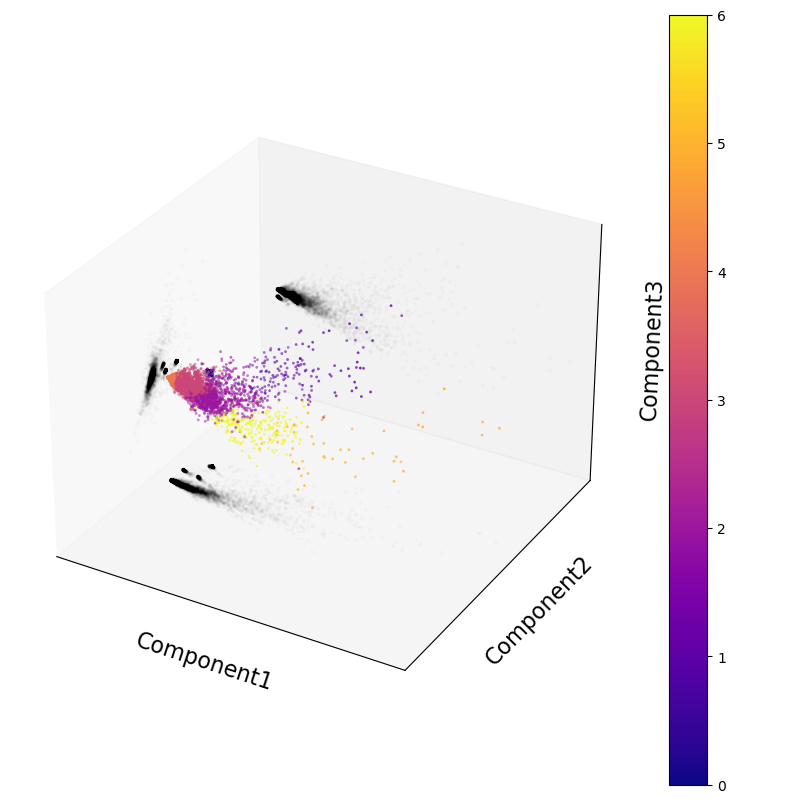

In [109]:
color = yhat

plot3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], color, shadow=True, xLabel = 'Component1', yLabel = 'Component2', zLabel = 'Component3')

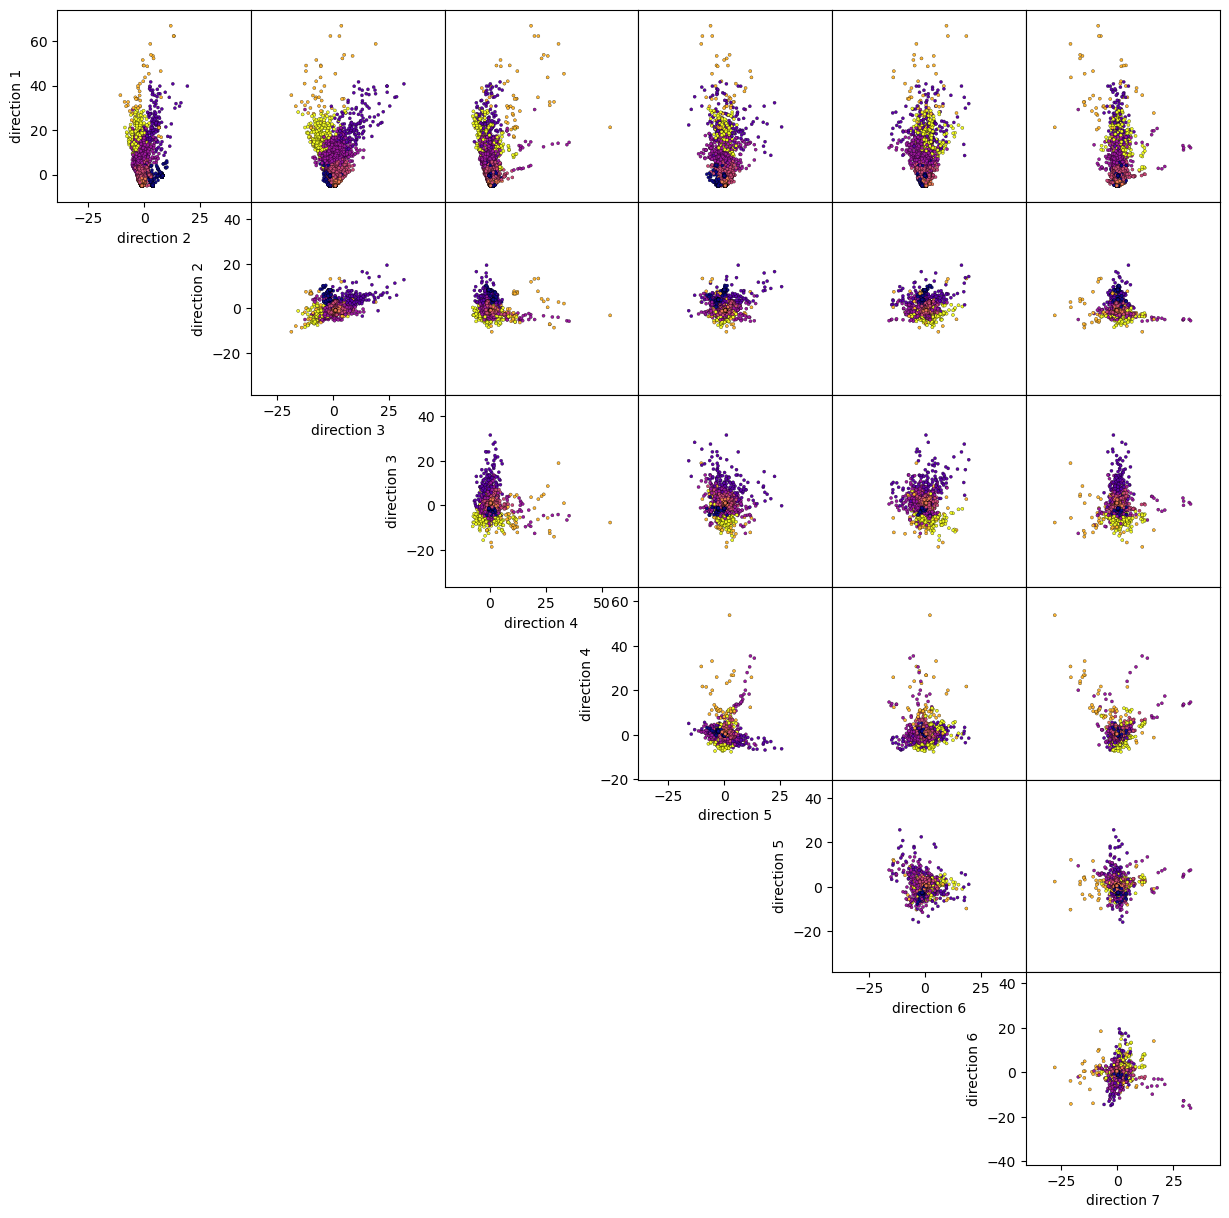

In [110]:
trianglePlot(arry = X_transformed, clist = color, dim = 6)

In [111]:
schools = cleaned_institutional_finance_no_outliers.index
if_cluster = yhat
if_cluster_all_years = pd.DataFrame({"if_cluster": if_cluster}, index = schools) 

In [112]:
if_cluster_df = if_cluster_all_years.groupby(if_cluster_all_years.index).agg(pd.Series.mode)

In [113]:
if_cluster_df.to_csv("../datasets/Clusters/IF_CLUSTER.csv")

### Exploring Cluster Characteristics